# Create a dataset using alpha vantage

In [109]:
try:
    import alpha_vantage
except:
    ! pip install alpha_vantage
    import alpha_vantage

import requests
from pprint import pprint
import csv
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime, timedelta
import json
import time
from tqdm import tqdm
import os
sns.set()
pd.set_option('display.max_colwidth',1000)

## get all tickers from alpha vantange api

In [83]:
def get_symbols(start_date=0, end_date=0):
    # API KEY: NG88F4E3M06AUO7C
    # API KEY: API_KEY
    # API KEY: 9XZQZQZQZQZQZQZQ
    # API KEY: demo
    CSV_URL = 'https://www.alphavantage.co/query?function=LISTING_STATUS&apikey=demo'
    return pd.read_csv(CSV_URL)

tickers = get_symbols()

### Do some pre-processing on the dataset to make it a bit more presentable

In [84]:
# set the index of the dataframe to the ticker symbol
tickers.set_index('symbol', inplace=True)
# sort the dataframe according to the date
tickers.sort_values('ipoDate', inplace=True)
# remove lines where delistingDate is not null
tickers = tickers[tickers['delistingDate'].isnull() & tickers['status'].str.contains('Active')]
# remove the delistingDate column
tickers.drop('delistingDate', axis=1, inplace=True)
# remove the status column
tickers.drop('status', axis=1, inplace=True)
# find any duplicates in the name column and remove the earliest ones from the dataframe
tickers.drop_duplicates(subset='name', keep='last', inplace=True)
# convert ipoDate to datetime and parse out the year of the IPO from the ipoDate column
tickers['ipoDate'] = pd.to_datetime(tickers['ipoDate'])
tickers['ipoYear'] = tickers['ipoDate'].dt.year
print(tickers.describe())
tickers

            ipoYear
count  11115.000000
mean    2012.311381
std       11.018321
min     1962.000000
25%     2006.000000
50%     2017.000000
75%     2021.000000
max     2023.000000


,name,exchange,assetType,ipoDate,ipoYear
symbol,,,,,
GE,General Electric Company,NYSE,Stock,1962-01-02,1962
CAT,Caterpillar Inc,NYSE,Stock,1962-01-02,1962
KO,Coca-Cola Company,NYSE,Stock,1962-01-02,1962
BA,Boeing Company,NYSE,Stock,1962-01-02,1962
IBM,International Business Machines Corp,NYSE,Stock,1962-01-02,1962
...,...,...,...,...,...
CVMC,Calvert US Mid-Cap Core Responsible Index ETF,NYSE ARCA,ETF,2023-02-01,2023
PBT,Permian Basin Royalty Trust,NYSE,Stock,2023-02-01,2023
ZSPY,ASYMmetric Smart Alpha S&P 500 ETF,NYSE ARCA,ETF,2023-02-01,2023


In [85]:
# locate the row containing the symbol aapl
pprint(tickers.loc['AAPL'])

name                   Apple Inc
exchange                  NASDAQ
assetType                  Stock
ipoDate      1980-12-12 00:00:00
ipoYear                     1980
Name: AAPL, dtype: object


### Plot the histogram with the number of ipos in the x axis

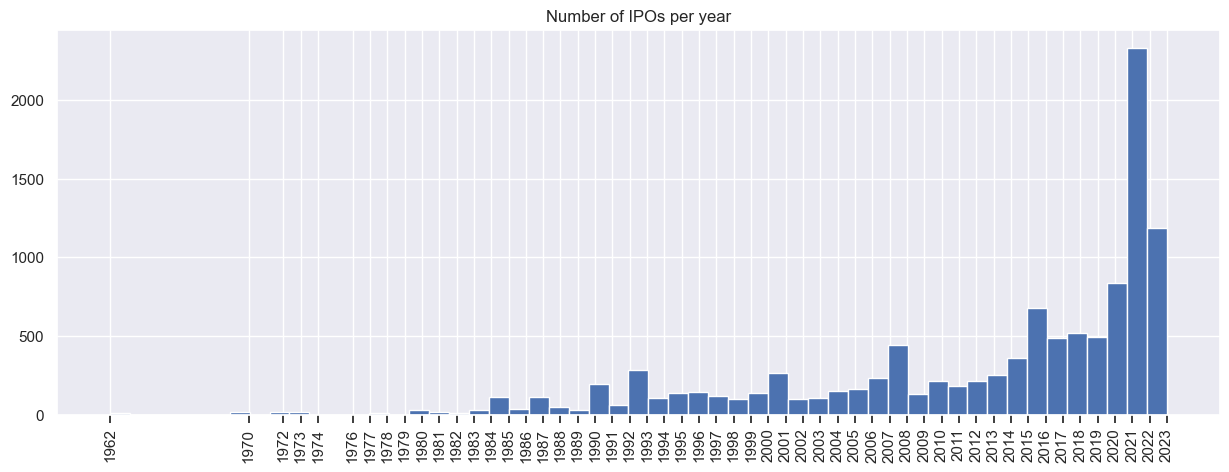

In [86]:
# get the number of unique values in the ipoYear column
years = tickers['ipoYear'].nunique()
# plot a histogram of the number of IPOs per year and show all the years on the x-axis
tickers['ipoYear'].hist(bins=years, xrot=90, figsize=(15, 5), align='mid')
plt.title('Number of IPOs per year')
plt.xticks(tickers['ipoYear'].unique())
# move all x ticks to the left
plt.gca().xaxis.tick_bottom()
plt.show()

In [87]:
# save the dataframe to a csv file
tickers.to_csv('tickers.csv')

## Build the news sentiments dataset

In [152]:
def get_sentiments(company_symbol: str = '', news_topic: str = '', time_from: str = '', time_to: str = '', sort_by: str = 'RELEVANCE'):
    keys = ['API_KEY', 'YOUR_API_KEY', '9XZQZQZQZQZQZQZQ', 'TQ82I6FBRGST0SWG', 'NG88F4E3M06AUO7C', 'BVLIQRCET4I22OM8', '55AYQEHU4F19W8YS', '2AUO2G9N2BT4FMT6']
    # API KEY: NG88F4E3M06AUO7C
    # API KEY: BVLIQRCET4I22OM8
    # API KEY: 55AYQEHU4F19W8YS
    endpoint = "https://www.alphavantage.co/query"
    for key in keys:
        parameters = {
            "function": "NEWS_SENTIMENT",
            "sort": sort_by,
            "limit": "200",
            "apikey": "YOUR_API_KEY",
        }
        if time_from and time_to: parameters['time_from'] = time_from; parameters['time_to'] = time_to
        if news_topic: parameters['topics'] = news_topic
        if company_symbol: parameters['tickers'] = company_symbol
        # Send a GET request to the API endpoint
        response = requests.get(endpoint, params=parameters)
        # Check if the request was successful
        if response.status_code == 200:
            data = response.json()
            if 'Note' in data: print('api overuse'); continue
            return data
        else: print(response)

# pprint(get_sentiments())

{'feed': [{'authors': ['Benzinga Insights'],
           'banner_image': 'https://www.benzinga.com/next-assets/images/schema-image-default.png',
           'category_within_source': 'Markets',
           'overall_sentiment_label': 'Neutral',
           'overall_sentiment_score': -0.146716,
           'source': 'Benzinga',
           'source_domain': 'www.benzinga.com',
           'summary': 'What happened: On Wednesday a total of 5,442.39 Ether '
                      'ETH/USD worth $9,138,907, based on the current value of '
                      'Ethereum at time of publication ( $1,679.21 ) , was '
                      'burned from Ethereum transactions. Burning is when a '
                      'coin or token is sent to an unusable wallet to remove '
                      'it from circulation.',
           'ticker_sentiment': [{'relevance_score': '0.999304',
                                 'ticker': 'CRYPTO:ETH',
                                 'ticker_sentiment_label': 'Somewhat

### Download all news sentiments from the past 100 days

In [154]:
# get the datetime of the past week in the format: YYYYMMDDTHHMM
def sweep_news_in_range(start_time: datetime):
    # todo make this more concise
    # create a dir called sentiments if it doesn't exist
    if not os.path.exists('sentiments'): os.mkdir('sentiments')
    sentiment_list = []
    # get the news up to 100 days ago. and every 5 iterations of action, sleep for one second
    for i in tqdm(range(20)):
        # repeat the process for ealiest and latest
        for sort_by in ['EARLIEST', 'LATEST']:
            for j in range(5):
                time_to = (start_time - timedelta(days=i*5+j)).strftime('%Y%m%dT%H%M')
                time_from = (start_time - timedelta(days=i*5+j+1)).strftime('%Y%m%dT%H%M')
                # get the news sentiment for the past week
                sentiment = get_sentiments(news_topic='financial_markets', time_from=time_from, time_to=time_to, sort_by=sort_by)
                if not sentiment: return sentiment_list
                # temporarily save the sentiments to a json file in a folder called sentiments
                with open(os.path.join('sentiments', f'sentiments{time_from}.json'), 'w') as f:
                    json.dump(sentiment, f, indent=4)
                # append the sentiment to the list
                sentiment_list.append(sentiment)
        time.sleep(10)
    return sentiment_list

# start sweeping from right now, for older sweeps change datetime to datetime.now() - timedelta(days=num_days_past)
all_news = sweep_news_in_range(datetime.now())

100%|██████████| 20/20 [06:52<00:00, 20.63s/it]


### Create a dataframe of the sentiments grouped by ticker symbols and sorted by time

In [157]:
ordered_sentiments = []
for news in tqdm(all_news):
    # temp addition
    if 'Note' in news: continue
    for article in news['feed']:
        # parse date time from YYYYMMDDTHHMM format to datetime object
        time_pub = datetime.strptime(article['time_published'], '%Y%m%dT%H%M%S')
        ordered_sentiments.append({'ticker': None, 'sentiment': article['overall_sentiment_score'], 'time': time_pub, 'url': article['url']})
        for tickers_sents in article['ticker_sentiment']:
            ordered_sentiments.append({'ticker': tickers_sents['ticker'], 'sentiment': tickers_sents['ticker_sentiment_score'], 'time': time_pub, 'url': article['url']})

100%|██████████| 200/200 [00:00<00:00, 1562.07it/s]


In [169]:
# create a dataframe from the list of dictionaries
# remove duplicates caused by the same article being published on multiple websites or downloading multiple times using the sort_by
sent_df = pd.DataFrame(ordered_sentiments).drop_duplicates(keep='last').sort_values(by='time', ascending=False).set_index('ticker')
start_time, end_time = sent_df.iloc[0]['time'].strftime('%d_%m_%Y'), sent_df.iloc[-1]['time'].strftime('%d_%m_%Y')
# save the dataframe to a csv file
sent_df.to_csv(f'sentiments_{start_time}_{end_time}.csv')
sent_df

,sentiment,time,url
ticker,,,
JXN,0.095073,2023-01-30 23:00:21,https://www.zacks.com/stock/news/2046606/jackson-financial-jxn-dips-more-than-broader-markets-what-you-should-know
NaN,0.172666,2023-01-30 23:00:21,https://www.zacks.com/stock/news/2046609/macys-m-gains-as-market-dips-what-you-should-know
AMN,0.16008,2023-01-30 23:00:21,https://www.zacks.com/stock/news/2046607/amn-healthcare-services-amn-stock-moves--088-what-you-should-know
NaN,0.103864,2023-01-30 23:00:21,https://www.zacks.com/stock/news/2046607/amn-healthcare-services-amn-stock-moves--088-what-you-should-know
M,0.11696,2023-01-30 23:00:21,https://www.zacks.com/stock/news/2046609/macys-m-gains-as-market-dips-what-you-should-know
...,...,...,...
NaN,0.096544,2022-04-12 20:40:00,https://www.newswire.ca/news-releases/halo-collective-announces-westwood-dispensary-completion-local-inspections-passed-and-planned-opening-for-second-budega-tm-in-california-885314339.html
AKAN,0.064576,2022-04-12 20:40:00,https://www.newswire.ca/news-releases/halo-collective-announces-westwood-dispensary-completion-local-inspections-passed-and-planned-opening-for-second-budega-tm-in-california-885314339.html
DRNK,0.347181,2022-04-12 20:40:00,https://www.newswire.ca/news-releases/halo-collective-announces-westwood-dispensary-completion-local-inspections-passed-and-planned-opening-for-second-budega-tm-in-california-885314339.html


KeyError: "None of ['ticker'] are in the columns"

In [ ]:
sent_df.groupby('ticker').describe()